# Visualize "mutation matrices"

Using the data generated in the `MutationMatrices` notebook.

This visualizes mutation matrices both for codons (e.g. ATG, TGC) and amino acids (e.g. M, C).

In [1]:
%run "Header.ipynb"

## Load JSON mutation matrix data

These files are relatively small, compared with the huge (ish) JSONs generated by the main workflow code. So, thankfully, fiddling around with these plots on a laptop is pretty doable.

In [2]:
import json
with open("matrix-jsons/codon2codon2freq.json", "r") as f:
    codon2codon2freq = json.load(f)
    
with open("matrix-jsons/codon2freq.json", "r") as f:
    codon2freq = json.load(f)
    
with open("matrix-jsons/aa2aa2freq.json", "r") as f:
    aa2aa2freq = json.load(f)
    
with open("matrix-jsons/aa2freq.json", "r") as f:
    aa2freq = json.load(f)

## Check codon/amino acid frequencies

Just for reference.

In [3]:
print(codon2freq)
# Based on https://stackoverflow.com/a/280156.
maxfreqcodon = max(codon2freq, key=codon2freq.get)
print("Max freq codon: {} (freq = {:,})".format(maxfreqcodon, codon2freq[maxfreqcodon]))
minfreqcodon = min(codon2freq, key=codon2freq.get)
print("Min freq codon: {} (freq = {:,})".format(minfreqcodon, codon2freq[minfreqcodon]))

{'AAA': 86444, 'AAC': 41595, 'AAG': 37010, 'AAT': 53365, 'ACA': 32456, 'ACC': 28307, 'ACG': 13763, 'ACT': 24591, 'AGA': 20919, 'AGC': 24363, 'AGG': 5166, 'AGT': 22882, 'ATA': 43216, 'ATC': 35983, 'ATG': 45761, 'ATT': 55291, 'CAA': 37906, 'CAC': 17672, 'CAG': 18974, 'CAT': 15135, 'CCA': 15868, 'CCC': 19564, 'CCG': 12134, 'CCT': 17461, 'CGA': 9510, 'CGC': 25419, 'CGG': 2891, 'CGT': 19103, 'CTA': 16616, 'CTC': 32241, 'CTG': 20153, 'CTT': 34970, 'GAA': 67444, 'GAC': 42135, 'GAG': 53060, 'GAT': 57567, 'GCA': 46343, 'GCC': 35386, 'GCG': 14766, 'GCT': 40259, 'GGA': 41601, 'GGC': 34391, 'GGG': 9049, 'GGT': 34099, 'GTA': 30934, 'GTC': 21570, 'GTG': 28077, 'GTT': 33417, 'TAA': 2860, 'TAC': 23213, 'TAG': 889, 'TAT': 48848, 'TCA': 24160, 'TCC': 15665, 'TCG': 12011, 'TCT': 19511, 'TGA': 1877, 'TGC': 12145, 'TGG': 18933, 'TGT': 10917, 'TTA': 34427, 'TTC': 34147, 'TTG': 28216, 'TTT': 49692}
Max freq codon: AAA (freq = 86,444)
Min freq codon: TAG (freq = 889)


In [4]:
print(aa2freq)
maxfreqaa = max(aa2freq, key=aa2freq.get)
print("Max freq amino acid/stop codon: {} (freq = {:,})".format(maxfreqaa, aa2freq[maxfreqaa]))
minfreqaa = min(aa2freq, key=aa2freq.get)
print("Min freq amino acid/stop codon: {} (freq = {:,})".format(minfreqaa, aa2freq[minfreqaa]))

{'M': 45761, 'G': 119140, 'S': 118592, 'Q': 56880, 'F': 83839, 'A': 136754, 'P': 65027, 'I': 134490, 'Y': 72061, 'L': 166623, 'W': 18933, 'N': 94960, 'T': 99117, 'D': 99702, 'H': 32807, 'K': 123454, 'E': 120504, 'C': 23062, 'V': 113998, '*': 5626, 'R': 83008}
Max freq amino acid/stop codon: L (freq = 166,623)
Min freq amino acid/stop codon: * (freq = 5,626)


## Actually visualize matrices

Much of the matplotlib code in this function is based on [these docs](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html).

We define some utility functions first which can be used with generalized "obj"s instead of codons or amino acids specifically. This is because most of the code generalizes to both types of matrix.

The general idea of "you might as well define your own functions for this" was another thing I derived from the aforementioned matplotlib docs.

In [5]:
# Get the tab20 color map. This returns an object that we can call with, e.g. (0) to get the first
# color, (1) to get the second color, etc. See https://stackoverflow.com/a/25408562.
# (List of matplotlib color maps: https://matplotlib.org/stable/gallery/color/colormap_reference.html)
cmap = matplotlib.cm.get_cmap("tab20")
colors = [cmap(i) for i in range(20)]
hexcolors = [matplotlib.colors.to_hex(c) for c in colors]

# Map the 20 amino acids to a unique tab20 color, and then keep the stop codon (item 21)'s text color as black
# so that it has a unique color.
aa2color = {}
aas = sorted(list(aa2freq.keys()))
aas.remove("*")
for i, aa in enumerate(aas):
    aa2color[aa] = hexcolors[i]
aa2color["*"] = "#000000"

aa2color

{'A': '#1f77b4',
 'C': '#aec7e8',
 'D': '#ff7f0e',
 'E': '#ffbb78',
 'F': '#2ca02c',
 'G': '#98df8a',
 'H': '#d62728',
 'I': '#ff9896',
 'K': '#9467bd',
 'L': '#c5b0d5',
 'M': '#8c564b',
 'N': '#c49c94',
 'P': '#e377c2',
 'Q': '#f7b6d2',
 'R': '#7f7f7f',
 'S': '#c7c7c7',
 'T': '#bcbd22',
 'V': '#dbdb8d',
 'W': '#17becf',
 'Y': '#9edae5',
 '*': '#000000'}

In [23]:
import copy
import skbio

def viz_mutmatrix(
    objs,
    obj2freq,
    obj2obj2freq,
    objdesc,
    cmap_name,
    show_syn_nonsyn_vectors=False,
    w=22,
    h=22,
    rotate_xlabels=True,
    show_ticks=True,
    normalize_rows=True,
    figfilename=None
):
    """Visualizes a mutation matrix.
    
    In theory this function was supposed to be all generalized and fancy and stuff, but then adding
    Syn/NonSyn vectors for the codon matrix resulted in a ton of complexity... oh well. It works!
    
    objs: list
        Sorted list of objects (e.g. codon strings, amino acid strings). This order will be used for
        the x and y axes of the plot.
        
    obj2freq: dict
        Maps object strings (the stuff in objs) to their frequencies in the dataset. These frequencies
        will be shown as text in the diagonal of the matrix.
        
    obj2obj2freq: dict
        Maps object strings to another dict. Each dict (the value of key "o1") maps all of the other
        object strings besides o1 to the frequency with which we saw a mutation from o1 into these other
        objects. (So -- if we're working with codons, for example -- then the outermost dict should have
        64 elements and each inner dict should have 63 elements.)
        
    objdesc: str
        Name of the object, in title-case (e.g. "Codon"). Used in adding labels/titles to the figure.
    
    cmap_name: str
        Name of the colormap to use in matplotlib.
        See https://matplotlib.org/stable/tutorials/colors/colormaps.html.
        
    show_syn_nonsyn_vectors: bool
        If True, this will interpret each of the objs as codons, and plot two extra vectors (represented
        as columns) next to the matrix. The value of each cell in Syn is the sum of all synonymous mutations
        in that row in the matrix; the value of each cell in NonSyn is the sum of all nonsynonymous mutations
        in that row in the matrix.
        
        This flag also controls a few other "codon-matrix-specific" things, e.g. coloring matrix cells as green
        or white depending on if they represent a synonymous or nonsynonymous mutation. Basically, this should be
        True for codon matrices and False for other matrices.
        
    w: some sort of number
    h: some sort of number
        The width and height, in inches, that we pass to fig.set_size_inches().
        
    rotate_xlabels: bool
        If True, will rotate the x-axis labels by -45 degrees. Useful if there are a lot of object strings
        and they each have multiple characters. If False, won't rotate these labels.
        
    show_ticks: bool
        If True, will show ticks next to axis labels; if False, won't (but will still show labels).
        
    normalize_rows: bool
        If True, this will divide each cell by the obj2freq entry for its row.
        
    figfilename: str or None
        If not None, this'll save the figure to this filename in figs/.
    """
    
    # Convert from a dict of dicts to just a 2D list, so we can use imshow.
    # The document I linked above uses NumPy arrays, but lists are ok also (...as far as I can tell).
    obj_matrix = []
    syn = []
    nonsyn = []
    # Search for min / max vals across both the matrix and Syn and NonSyn -- we want them to use the same
    # scale to simplify interpretation, and the way to do this is to figure out the global min and max.
    # See https://stackoverflow.com/a/34183501.
    min_val = float("inf")
    max_val = float("-inf")
    for row_obj in objs:
        row = []
        rowsyn = 0
        rownonsyn = 0
        for col_obj in objs:
            if row_obj == col_obj:
                # We don't have data for "mutations" for an object into itself, so we assign the diagonal
                # of the matrix a special NaN value. And we'll later assign these NaN values a unique color.
                # See https://stackoverflow.com/a/46649061.
                row.append(float("nan"))
            else:
                raw_freq = obj2obj2freq[row_obj][col_obj]
                if normalize_rows:
                    freq = raw_freq / obj2freq[row_obj]
                else:
                    freq = raw_freq
                min_val = min(min_val, freq)
                max_val = max(max_val, freq)
                row.append(freq)
                if show_syn_nonsyn_vectors:
                    is_synonymous = (str(skbio.DNA(row_obj).translate()) == str(skbio.DNA(col_obj).translate()))
                    if is_synonymous:
                        rowsyn += freq
                    else:
                        rownonsyn += freq
        obj_matrix.append(row)
        if show_syn_nonsyn_vectors:
            syn.append([rowsyn])
            nonsyn.append([rownonsyn])
            min_val = min(min_val, rowsyn)
            min_val = min(min_val, rownonsyn)
            max_val = max(max_val, rowsyn)
            max_val = max(max_val, rownonsyn)

    if show_syn_nonsyn_vectors:
        # Use of width ratios based on https://matplotlib.org/stable/tutorials/intermediate/gridspec.html,
        # which I found myself at from https://stackoverflow.com/a/5084192 and the other answers therein.
        # Other stuff on the gridspec docs page didn't work for me for some reason (constrained_layout
        # didn't seem available? I might've just been doing stuff wrong); however, using gridspec_kw seems ok.
        #
        # The reason we use these particular ratios is that we can think of Syn and NonSyn as each being roughly
        # 1 column from the 64x64 matrix. The extra stuff here is to account for axis ticks, labels, etc.
        #
        # (There's probably a more precise way of setting this up, but this is probably fine...)
        fig, (ax, axSyn, axNonSyn) = pyplot.subplots(nrows=1, ncols=3, sharey=True, gridspec_kw={
            "width_ratios": [64, 4, 3]
        })
    else:
        fig, ax = pyplot.subplots()

    # Given a colormap we want to use, modify it so that NaNs are assigned a special color.
    # Based on https://stackoverflow.com/a/46649061.
    # (Making a copy of the colormap first to avoid matplotlib warning about modifying a colormap in-place.
    # For some reason copy.deepcopy() doesn't remove the warning, but copy.copy() does.)
    cmap = copy.copy(matplotlib.cm.get_cmap(cmap_name))
    cmap.set_bad(color="#cccccc")
    im = ax.imshow(obj_matrix, cmap=cmap, vmin=min_val, vmax=max_val)
    
    # Show top ticks but not bottom ticks; also, show the x-axis labels
    # on top instead of on bottom.
    ax.tick_params(
        top=show_ticks, bottom=False, left=show_ticks, right=False,
        labeltop=True, labelbottom=False, labelleft=True, labelright=False
    )
    # https://stackoverflow.com/a/14406447
    ax.xaxis.set_label_position("top")
        
    # As in "tick i's". This specifies where to put all the ticks.
    tick_is = range(len(objs))
    ax.set_xticks(tick_is)
    ax.set_yticks(tick_is)
    
    # show Syn and NonSyn
    if show_syn_nonsyn_vectors:
        axSyn.imshow(syn, cmap=cmap, vmin=min_val, vmax=max_val)
        axNonSyn.imshow(nonsyn, cmap=cmap, vmin=min_val, vmax=max_val)
        axSyn.set_title("$Syn$")
        axNonSyn.set_title("$NonSyn$")
        
        for a in (axSyn, axNonSyn):
            a.grid(False)
            a.tick_params(
                bottom=False, labelbottom=False
            )
            
        axSyn.tick_params(labelleft=True)
        axNonSyn.tick_params(left=False)
    
    # Set assigned colors for amino acids based on aa2color.
    # Also set colors for codons based on their translations.
    # This method of setting colors based on https://stackoverflow.com/a/4762002.
    if show_syn_nonsyn_vectors:
        # This is for the codon matrix. We want to add an extra row to the x-axis labels showing
        # the translations, as well as an extra column to the y-axis labels also showing the translations.
        # We *could* mess around with actually creating a new row/column using some fancy stuff (e.g. as
        # shown here: https://stackoverflow.com/a/42763429), but we take a similar albeit simpler approach:
        # since we really just want to show a one-to-one mapping of codons -> amino acids (or stop codons),
        # we just modify each codon label to include its translation.
        toplabels = []
        leftlabels = []
        for oi, o in enumerate(objs):
            t = skbio.DNA(o).translate()
            toplabels.append(f"{t}\n{o}")
            leftlabels.append(f"{t} {o}")
        
        ax.set_xticklabels(toplabels)
        ax.set_yticklabels(leftlabels)
        axSyn.set_yticklabels(leftlabels)
        for axlabelset in (ax.get_xticklabels(), ax.get_yticklabels(), axSyn.get_yticklabels()):
            for tl in axlabelset:
                tl.set_color(aa2color[tl.get_text().split()[0]])
                # The x-axis, especially, gets kinda cramped. So we don't use a bold font weight.
                tl.set_fontweight("semibold")
                tl.set_fontfamily("monospace")
    else:
        ax.set_xticklabels(objs)
        ax.set_yticklabels(objs)
        for axlabelset in (ax.get_xticklabels(), ax.get_yticklabels()):
            for tl in axlabelset:
                tl.set_color(aa2color[tl.get_text()])
                tl.set_fontweight("bold")
                tl.set_fontfamily("monospace")

    # Hide the gridlines (which I'm pretty sure come from our use of the ggplot style for matplotlib in the
    # Header notebook -- here the gridlines get in the way).
    # https://stackoverflow.com/a/45149018
    ax.grid(False)
    
    # Show frequency info along the diagonal
    for obj_i in tick_is:
        freq = obj2freq[objs[obj_i]]
        freqstr = "{}k".format(round(freq / 1000))

        ax.text(
            obj_i, obj_i, freqstr,
            ha="center", va="center", color="black"
        )

    # Show raw frequency info for each non-diag cell    
    for i, row_obj in enumerate(objs):
        for j, col_obj in enumerate(objs):
            if row_obj != col_obj:
                raw_freq = obj2obj2freq[row_obj][col_obj]
                freqstr = "{}".format(raw_freq)
                # Show black or white text, depending on how this cell's value compares to the max.
                # This is a crude way of doing this; could also look at the luminosity (?) of this color.
                # But it looks ok enough :)
                # (I didn't notice until after I wrote this, but the example I linked in mpl's docs also does
                # something similar, albeit in a way that looks much more elegant :)
                if obj_matrix[i][j] / max_val > 0.5:
                    textcolor = "#000000"
                else:
                    textcolor = "#ffffff"
                if show_syn_nonsyn_vectors:
                    is_synonymous = (str(skbio.DNA(row_obj).translate()) == str(skbio.DNA(col_obj).translate()))
                    if is_synonymous:
                        # Color green, but make it either dark or light green based on the surrounding cell
                        # We use 0.6 instead of 0.5 as our cutoff because dark green kinda blends in with ~0.5
                        # on the Viridis scale really well (see: AAC -> AAT (325) on the unnormalized codon table)
                        # yeah we should cache the fraction and reuse it here but it's probs not a bottleneck
                        if obj_matrix[i][j] / max_val > 0.6:
                            textcolor = "#006000"
                        else:
                            textcolor = "#00ff00"
                    if textcolor == "#000000":
                        # Currently, we just say that nonsyn mutations are shown as white -- since as of writing
                        # the codon matrix only has green or white text -- all "light"-luminosity cells are syn
                        # mutations, as of writing. this error verifies that we can safely say this.
                        raise ValueError(
                            "This isn't really a problem but Marcus needs to update the codon matrix fig legends"
                        )
                # For a reason that escapes me, the x and y are flipped when calling ax.text() -- I think it has
                # to do with the location in ax.text() being in "data coordinates"
                # (https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html)
                # This flipping is also done in the example here:
                # https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
                ax.text(
                    j, i, freqstr,
                    ha="center", va="center", color=textcolor
                )
                
        
    ax.set_ylabel("Mutated from", fontsize=16)
    # Previously, this label was too close to the tick labels for comfort.
    # labelpad fixes this: https://stackoverflow.com/a/6406750
    ax.set_xlabel("Mutated into", fontsize=16, labelpad=10)

    title = "{} mutation frequencies".format(objdesc)
    if normalize_rows:
        title += " (cells normalized by row frequency listed on diagonal)"
    else:
        title += " (no normalization done)"
    
    if show_syn_nonsyn_vectors:
        fig.suptitle(title, y=1.02, x=0.4, fontsize=23)
    else:
        ax.set_title(title.format(objdesc), y=1.06, fontsize=18)
        
    fig.set_size_inches(w, h)
    # Call tight_layout() _before_ adding the colorbar, because otherwise matplotlib gets angry.
    # See https://stackoverflow.com/a/48922336.
    fig.tight_layout()
    
    # Set up a colorbar.
    # Position it to the right of whatever the rightmost subplot is.
    if show_syn_nonsyn_vectors:
        # We can just create the colorbar from a list of all the subplot axes:
        # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/colorbar_placement.html
        # Use aspect to smoosh the colorbar (by default it's very thick):
        # https://stackoverflow.com/a/41589776
        cb = fig.colorbar(im, ax=[ax, axSyn, axNonSyn], aspect=60, pad=0.02)
    else:
        # for some reason using the above technique (but with just ax=ax) results in the colorbar extending beyond
        # the matrix vertically. However, this technique _doesn't_ exhibit this problem. I do not know why.
        # matplotlib is hard.
        #
        # Also we use the size parameter to adjust the thickness of the colorbar here. For some reason that eludes
        # me, creating a colorbar with this method (which _also uses fig.colorbar()_) is not compatible with
        # passing an aspect parameter to the colorbar. So this means that colorbars created through this method
        # are probably slightly differently sized than colorbars created through the above method.
        # ...Fortunately, I don't think anyone cares about that.
        #
        # https://matplotlib.org/stable/gallery/axes_grid1/simple_colorbar.html
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        fig.colorbar(im, cax=cax)

    if figfilename is not None:
        fig.savefig("figs/{}".format(figfilename), bbox_inches="tight")

In [7]:
def plot_freq_distribution(obj2obj2freq, objdesc):
    # Despite the name, this is just a one-dimensional dict, where each key is a string
    # of format "AAA --> AAC" or something, and each value is just how many times we've seen this mutation.
    # So it's a differently-formatted version of obj2obj2freq, used for figuring out the most common mutations.
    o1_o2_to_freq = {}
    all_combos = []
    for row_obj in obj2obj2freq.keys():
        row = []
        for col_obj in obj2obj2freq.keys():
            if row_obj != col_obj:
                combo = "{} --> {}".format(row_obj, col_obj)
                all_combos.append(combo)
                o1_o2_to_freq[combo] = obj2obj2freq[row_obj][col_obj]

    print("Most common {} mutations:".format(objdesc.lower()))
    sorted_combos = sorted(all_combos, key=lambda c: o1_o2_to_freq[c])
    for ci, combo in enumerate(sorted_combos[-10:][::-1], 1):
        print("{}. {}: frequency {}".format(ci, combo, o1_o2_to_freq[combo]))

    pyplot.hist(o1_o2_to_freq.values(), log=True)
    pyplot.title("{} mutation frequency distribution".format(objdesc))
    pyplot.ylabel(
        "Number of unique {} mutations\n".format(objdesc.lower()) +
        "with this frequency (log$_{10}$ scale)"
    )
    pyplot.xlabel("{} mutation frequency in the data".format(objdesc))
    pyplot.show()

### Codon matrix

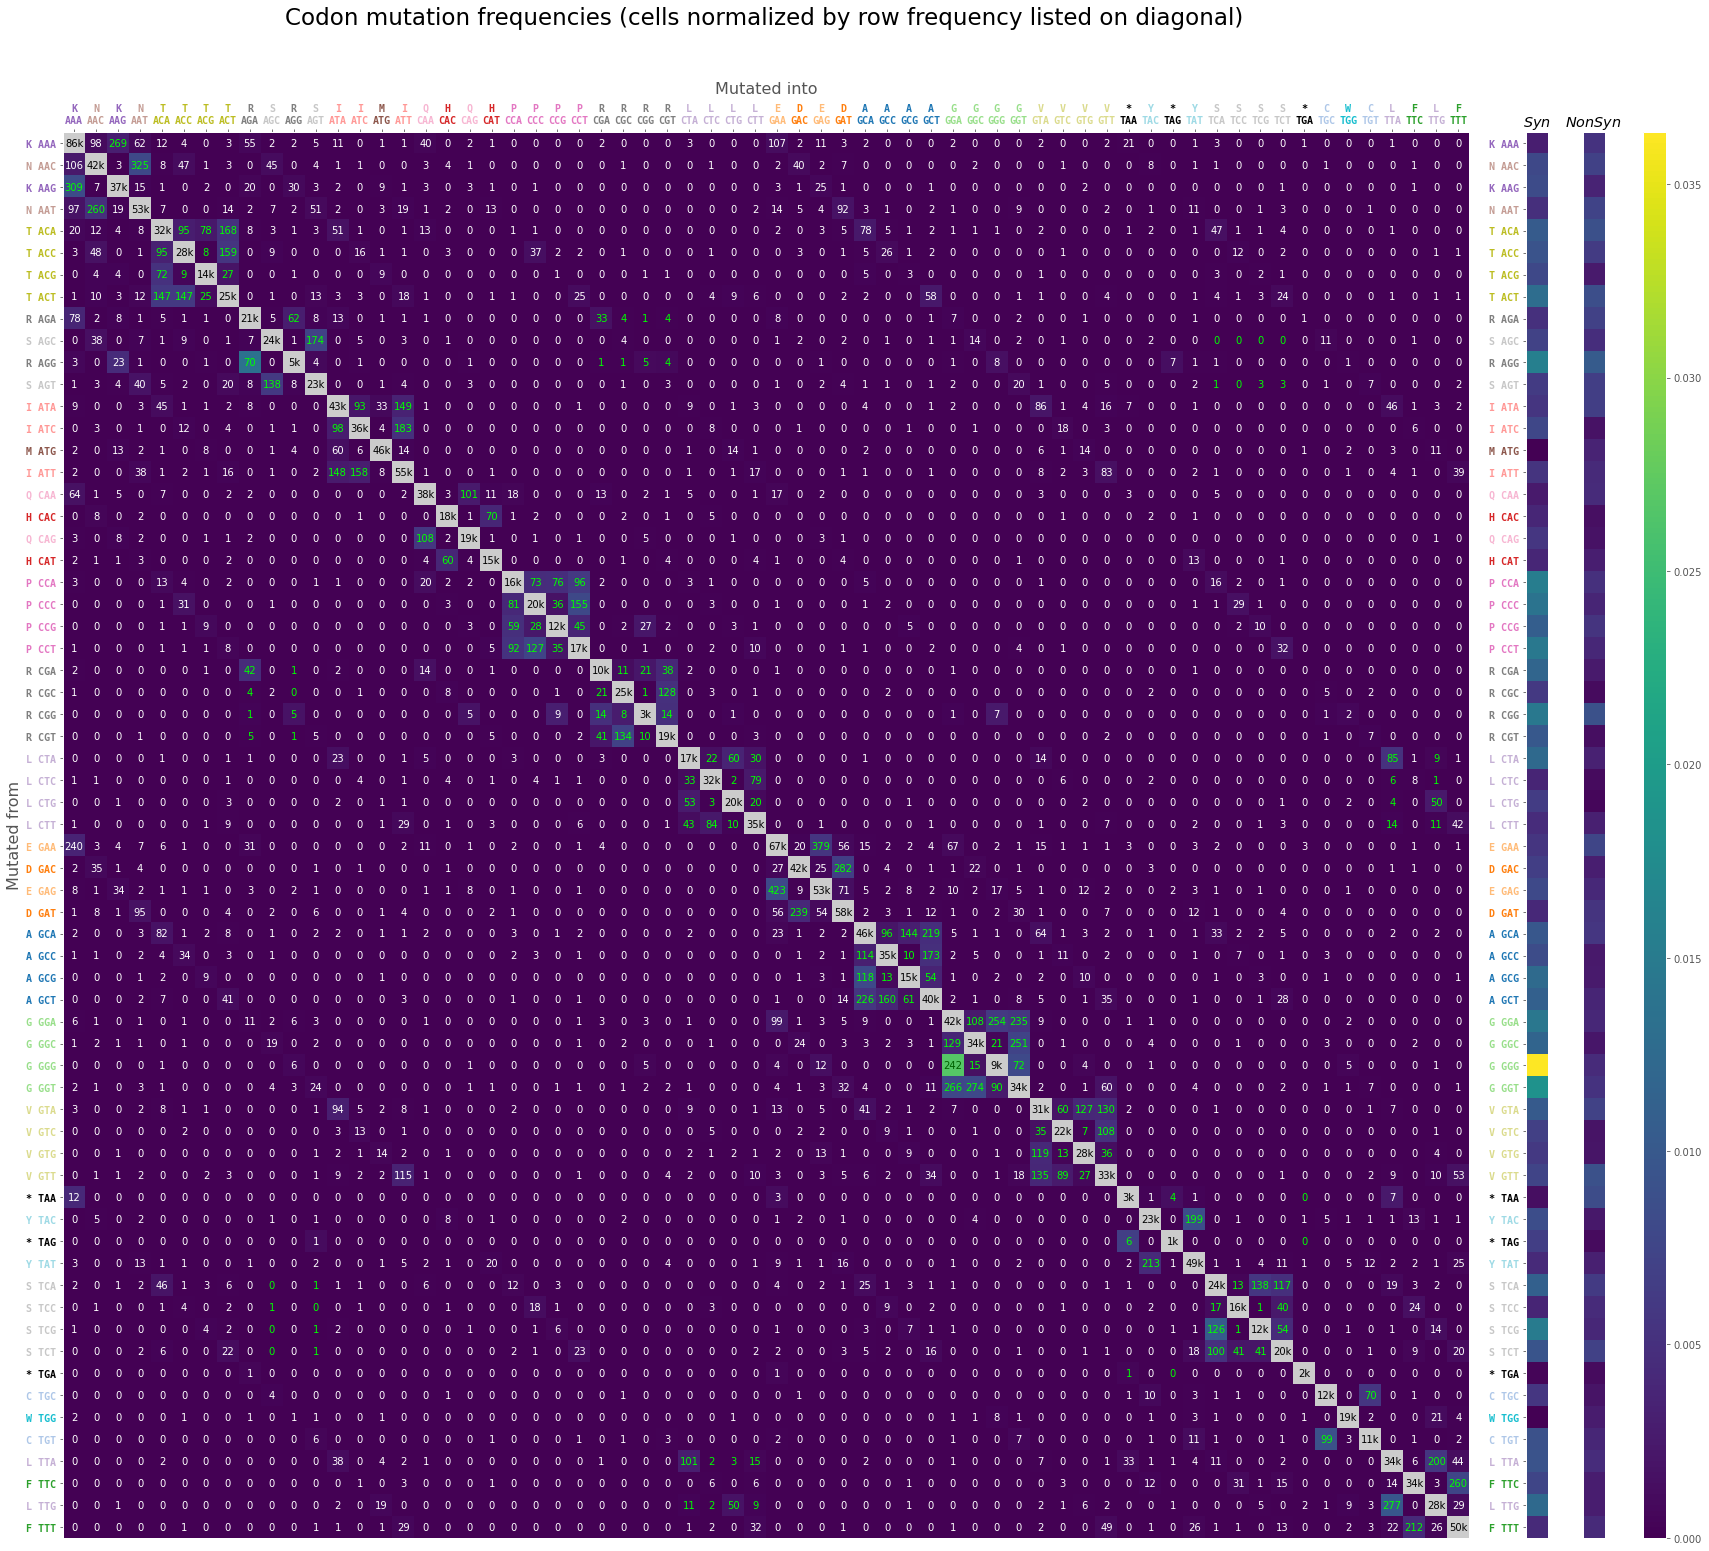

In [24]:
viz_mutmatrix(
    sorted(codon2freq.keys()), codon2freq, codon2codon2freq, "Codon",
    "viridis",
    show_syn_nonsyn_vectors=True,
    w=27.25, h=21,
    figfilename="codon-matrix.png"
)

Most common codon mutations:
1. GAG --> GAA: frequency 423
2. GAA --> GAG: frequency 379
3. AAC --> AAT: frequency 325
4. AAG --> AAA: frequency 309
5. GAC --> GAT: frequency 282
6. TTG --> TTA: frequency 277
7. GGT --> GGC: frequency 274
8. AAA --> AAG: frequency 269
9. GGT --> GGA: frequency 266
10. TTC --> TTT: frequency 260


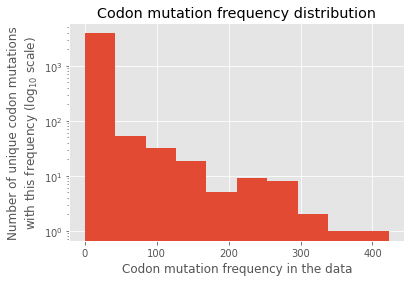

In [9]:
plot_freq_distribution(codon2codon2freq, "Codon")

### Amino acid (+ stop codon) matrix

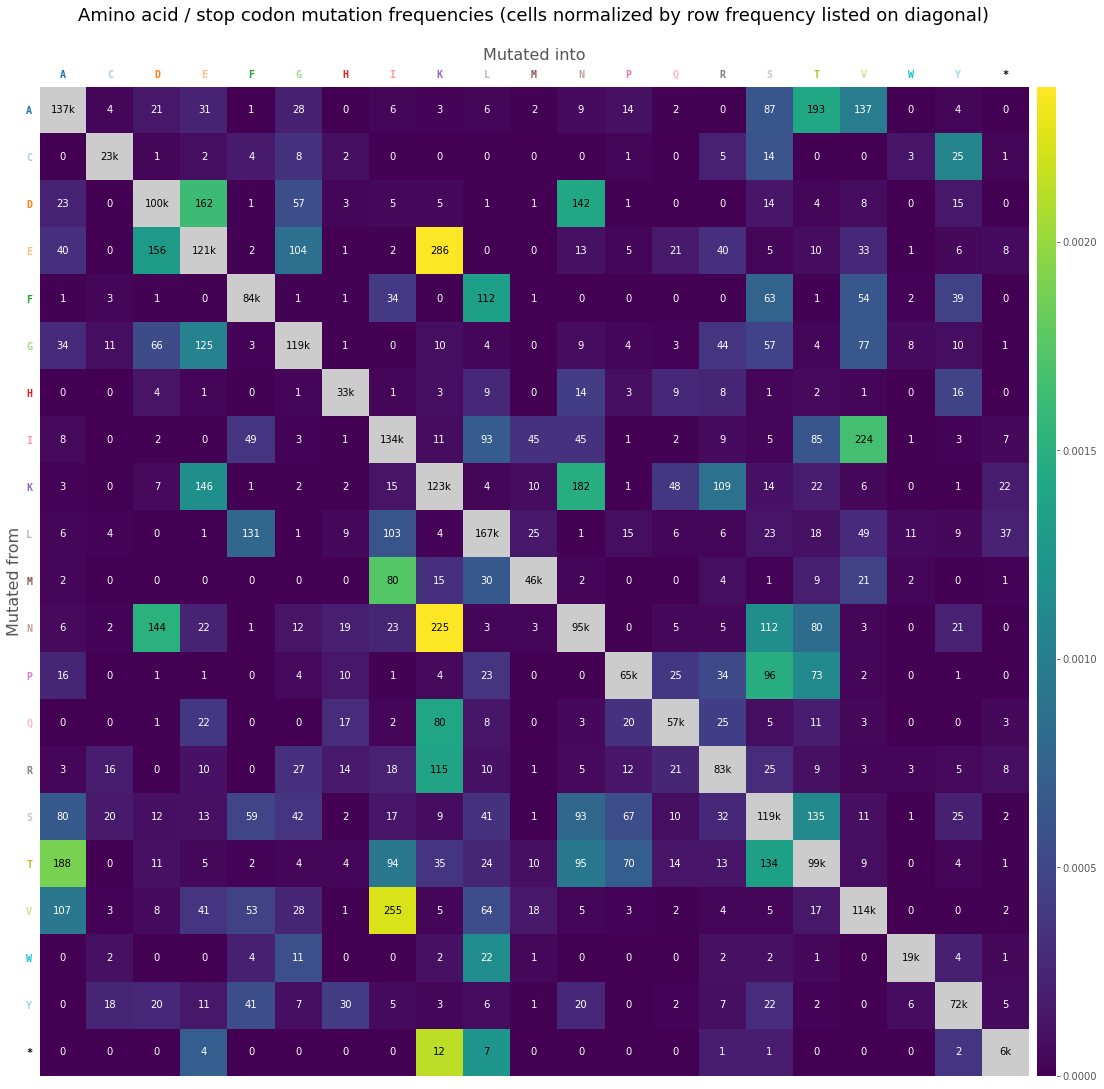

In [10]:
# Sorting will, by default, put the "*" (the stop codon) at the start of the list. To avoid this,
# we manually remove it from the list and then move it to the end (which IMO makes the most sense as
# a location for it relative to the actual amino acids).
aas = sorted(aa2freq.keys())
aas.remove("*")
aas += ["*"]
viz_mutmatrix(
    aas, aa2freq, aa2aa2freq, "Amino acid / stop codon",
    "viridis",
    w=15, h=15,
    rotate_xlabels=False,
    show_ticks=False,
    figfilename="aa-matrix.png"
)

Most common amino acid / stop codon mutations:
1. E --> K: frequency 286
2. V --> I: frequency 255
3. N --> K: frequency 225
4. I --> V: frequency 224
5. A --> T: frequency 193
6. T --> A: frequency 188
7. K --> N: frequency 182
8. D --> E: frequency 162
9. E --> D: frequency 156
10. K --> E: frequency 146


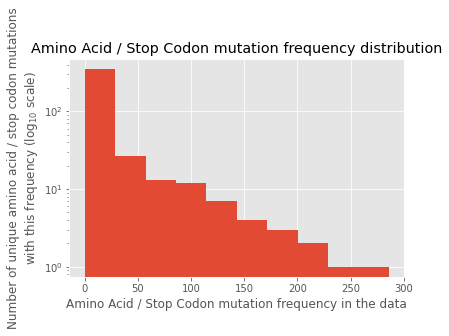

In [11]:
plot_freq_distribution(aa2aa2freq, "Amino Acid / Stop Codon")

### Matrices without row normalization

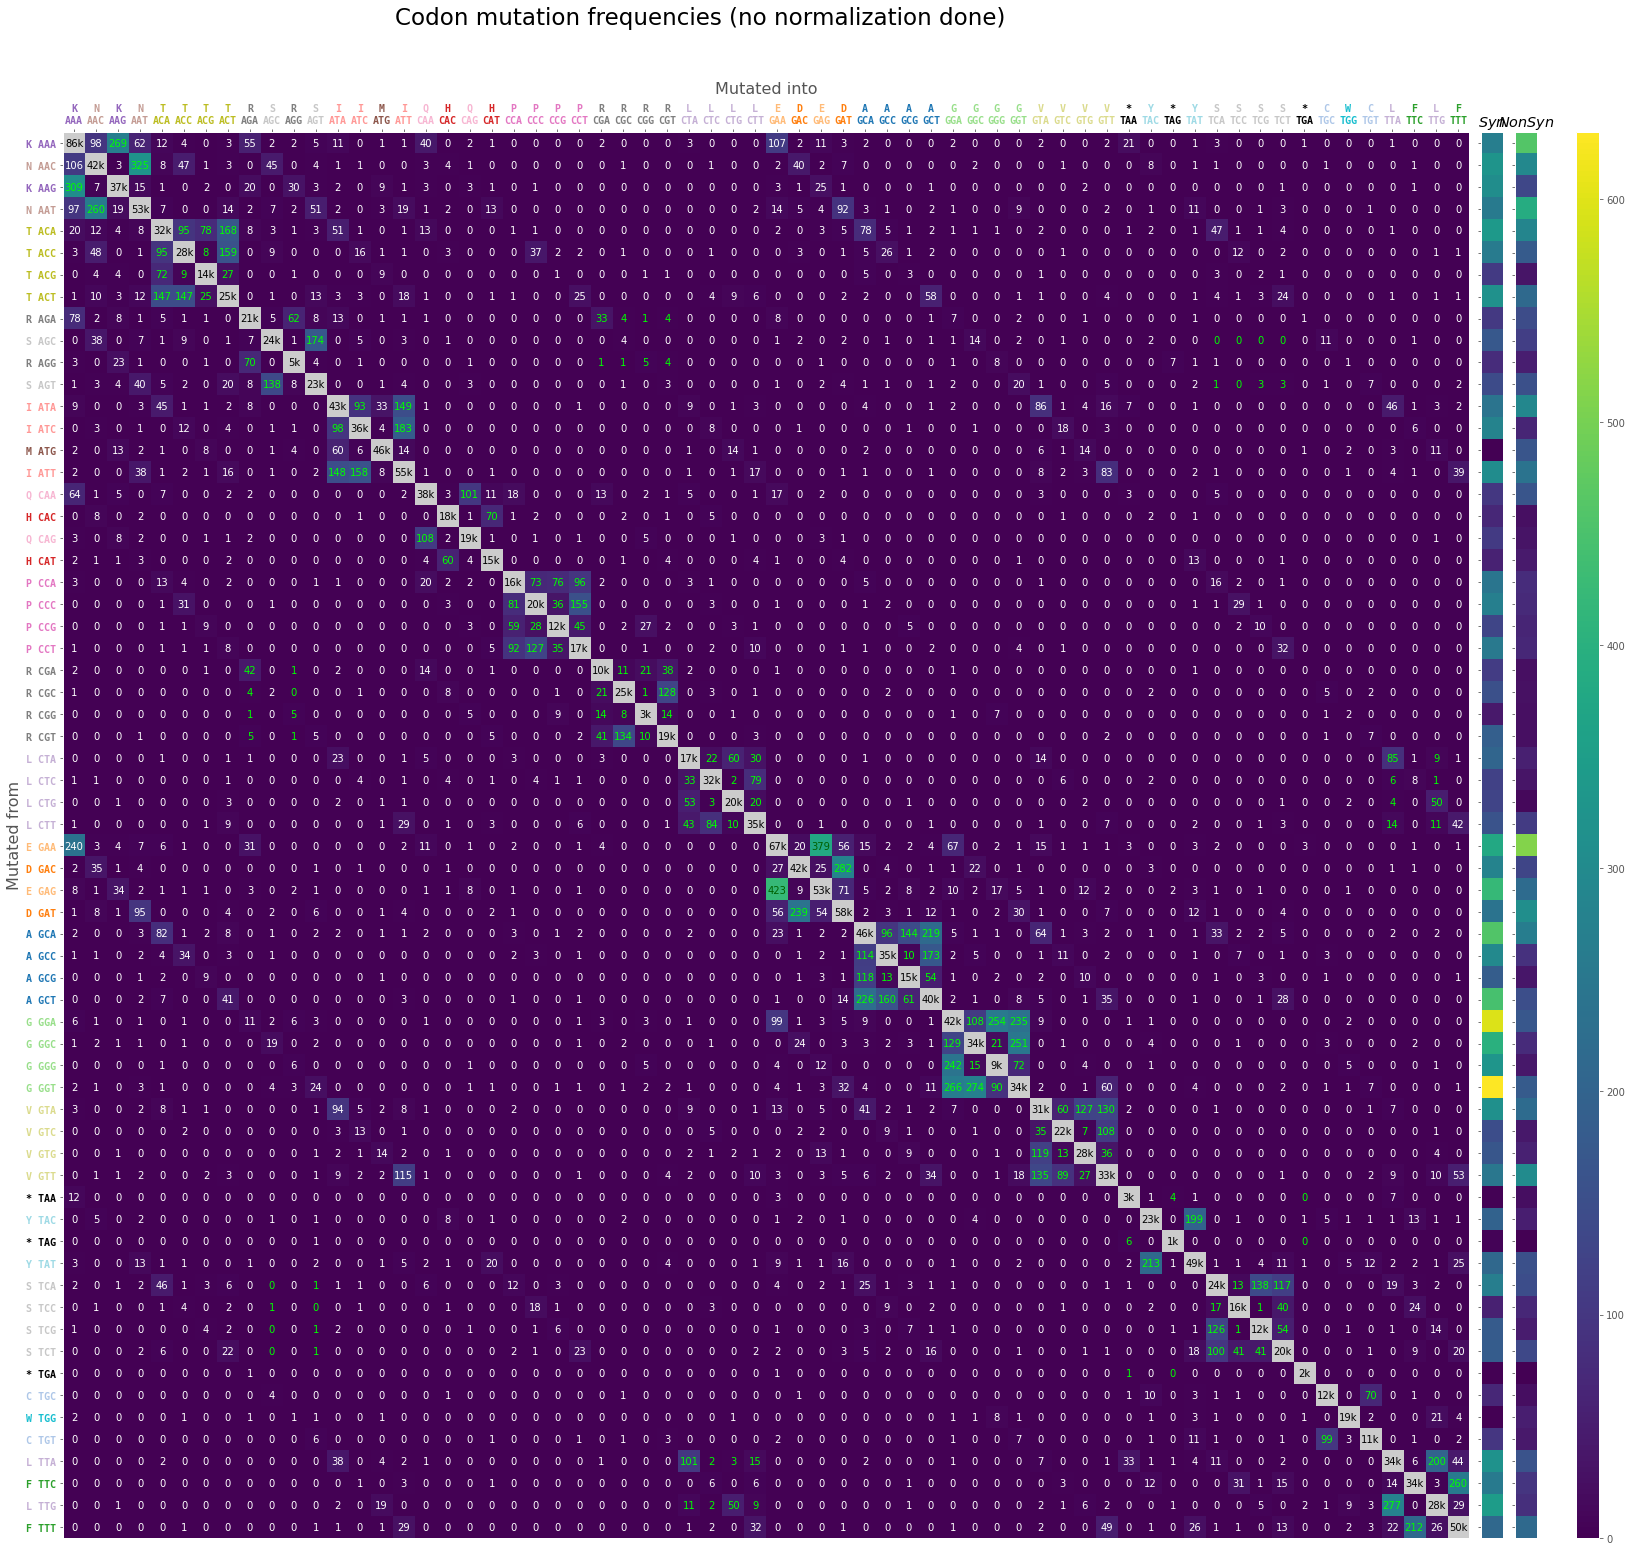

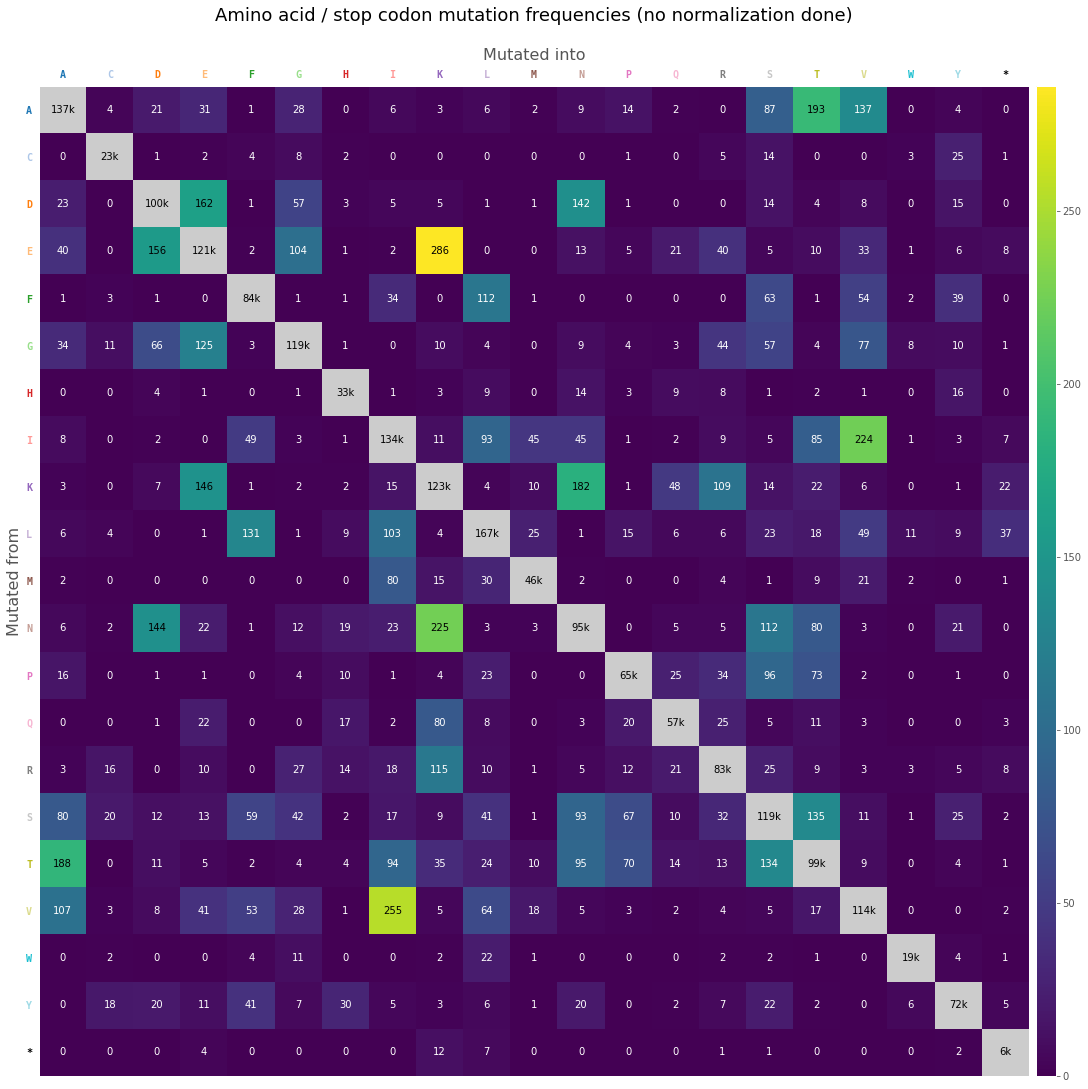

In [12]:
viz_mutmatrix(
    sorted(codon2freq.keys()), codon2freq, codon2codon2freq, "Codon",
    "viridis",
    show_syn_nonsyn_vectors=True,
    w=27.25, h=21,
    normalize_rows=False,
    figfilename="codon-matrix-unnorm.png"
)
viz_mutmatrix(
    aas, aa2freq, aa2aa2freq, "Amino acid / stop codon",
    "viridis",
    w=15, h=15,
    rotate_xlabels=False,
    show_ticks=False,
    normalize_rows=False,
    figfilename="aa-matrix-unnorm.png"
)